In [55]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from statsmodels.tools.tools import add_constant
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [70]:
df = pd.read_csv('FormattedData/MSFT_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [71]:
df.index = pd.to_datetime(df.index)

In [72]:
def remove_corrs(df):
    
    # create a DataFrame with all the of the correlation coefficients, and then stack the pairings.
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    # create a temoporary DataFrame that contains all the pairs of variables that have a correlation
    # between .8 and .999. Because the .corr() method returns the pairings in both directions, I only
    # look at half of the cells because of duplicates.
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    # look at how many times each variable shows up in the correlation column
    corr_index = correlations['1'].value_counts().index
    # delete the first 90% of the variables. This generally removes the columns that are most correlated with the others. 
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

### Train Test Split and Scaling Data

In [73]:
def preprocess_data(df):
    
    df.index = pd.to_datetime(df.index)
    
    # Here, I shift all the independent variables back one day in order to make sure there is
    # no data leakage. Because we're trying to predict closing price, we can't know many of
    # things that happen throughout the day we're trying to predict.
    X = df.shift(1).dropna()
    
    # This is the function described above.
    X_data = remove_corrs(X)

    # Because I am running a regression, I can use a continuous variable as my dependent variable.
    # Ideally, my algorithim can predict the closing price at the end of the day with accuracy.
    y = df['close'].iloc[1:]
    
    # Do a train test split with the first 80% of the data being the training set and the last 20%
    # as the testing set.
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)

    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    # Because I am doing distance based regressions, I need to scale the data so that variables with
    # higher absolute values don't dominate the metrics.
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = preprocess_data(df)

In [75]:
from statsmodels.regression.linear_model import OLS

In [76]:
exog_train = add_constant(X_train)
exog_test = add_constant(X_test)

In [77]:
lin_reg = OLS(y_train, exog_train, hasconst = True)

In [78]:
results = lin_reg.fit()

In [79]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.884e+04
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:00:19   Log-Likelihood:                -2969.9
No. Observations:                1798   AIC:                             5986.
Df Residuals:                    1775   BIC:                             6112.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.9171      0.552      5.288      0.000       1.835       3.999
low                        0.3763      0.049      7.619      0.000       0.279       0.473
volume                 -1.593e-09   2.15e-09     -0.742      0.458    -5.8e-09    2.61e-09
adjustedclose              0.6190      0.048     12.810      0.000       0.524       0.714
day_direction              0.1388      0.083      1.680      0.093      -0.023       0.301
rsi                        0.0018      0.005      0.350      0.726      -0.008       0.012
RSI_overbought_cross       0.2990      0.218      1.370      0.171      -0.129       0.727
RSI_oversold_cross         0.8541      0.915      0.934      0.350      -0.940       2.648
RSI_overbought             0.1391      0.145      0.961      0.337      -0.145       0.423
RSI_oversold              -0.2807      0.758     -0.370      0.711      -1.768       1.207
BBB_5_2.0                  0.0078      0.015      0.539      0.590      -0.021       0.036
BBP_5_2.0                  0.0199      0.175      0.113      0.910      -0.324       0.364
golden_crossover_short    -0.2681      0.261     -1.028      0.304      -0.780       0.243
death_crossover_short      0.2177      0.265      0.820      0.412      -0.303       0.738
golden_crossover_long      0.2775      0.746      0.372      0.710      -1.185       1.740
death_crossover_long      -0.0441      0.902     -0.049      0.961      -1.813       1.724
momentum                  -0.0241      0.013     -1.831      0.067      -0.050       0.002
psr                       -0.0793      0.053     -1.484      0.138      -0.184       0.026
ir                         0.3043      0.090      3.374      0.001       0.127       0.481
ffer                      -0.1915      0.100     -1.916      0.056      -0.388       0.005
sp500_return              -9.2770      5.287     -1.755      0.080     -19.647       1.093
sp500_BBB_5_2.0            0.0542      0.024      2.268      0.023       0.007       0.101
sp500_BBP_5_2.0            0.1534      0.162      0.945      0.345      -0.165       0.472
==============================================================================
Omnibus:                      470.350   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24971.287
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                      21.244   Cond. No.                     6.58e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
y_hat = lin_reg.predict(results.params, exog_test)

In [81]:
resids = y_hat - y_test

In [82]:
resids.sort_index(inplace=True)

<AxesSubplot:xlabel='date'>

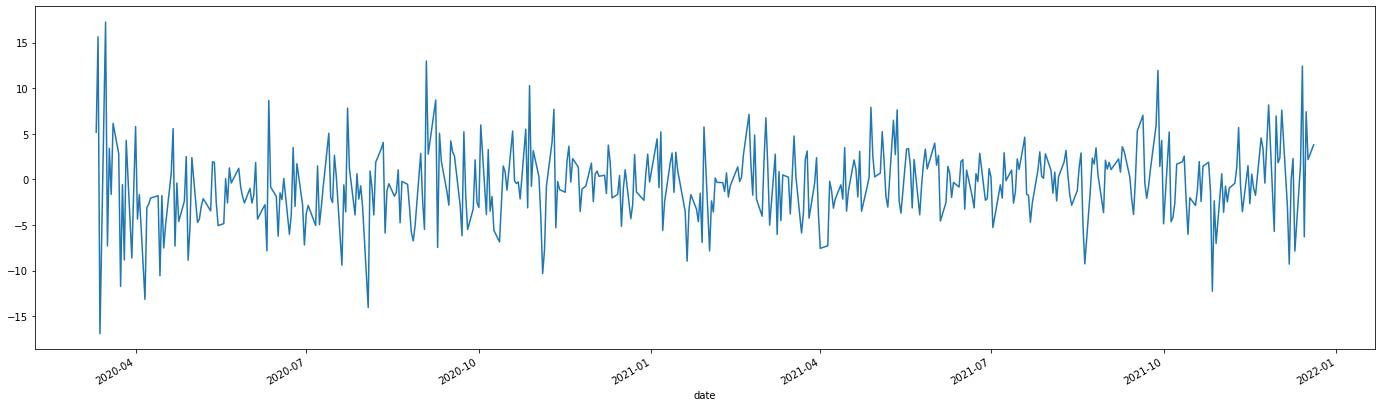

In [83]:
resids.plot(figsize = (24,7))